# 準備

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

FILE_SAVE = False
DEFAULT_COLOR = '#1f77b4'

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold
import pickle
import math

In [3]:
train = pd.read_csv("./data/train_processed_00.csv")

In [4]:
rf_model      = pickle.load(open("./data/rf_model_00.sav", 'rb'))
rf_model_cv = pickle.load(open("./data/rf_model_cv_00.sav", 'rb'))

In [5]:
#model_list = [rf_model_0, rf_model_best_0, rf_model_1, rf_model_best_1]
#model_names = ["rf_model_0", "rf_model_best_0", "rf_model_1", "rf_model_best_1"]

model_list = [rf_model]
model_names = ["rf_model_00"]

cv_model_list = [rf_model_cv]
best_model_names = ["rf_model_best_00"]

## 可視化関数

In [6]:
def plot_residuals(y_train_pred, y_test_pred):
    # 赤線に近いほど残差が少ない
    
    fig = plt.figure(figsize = (21, 5))

    # 予想値と残差収束
    ax = fig.add_subplot(131)
    ax.scatter(y_train_pred, y_train_pred - y_train, c = 'black', marker = 'o', s = 35, alpha = 0.5, label = 'Training data')
    ax.scatter(y_test_pred, y_test_pred - y_test, c = 'lightgreen', marker = 's', s = 35, alpha = 0.7, label = 'Test data')
    ax.set_xlabel('Predicted values')
    ax.set_ylabel('Residuals')
    ax.legend(loc = 'upper left')
    ax.hlines(y = 0, xmin = -10, xmax = 50, lw = 2, color = 'red')
    ax.set_xlim([-10, 50])

    # 実値と残差収束
    ax = fig.add_subplot(132)
    ax.scatter(y_train, y_train_pred - y_train, c = 'black', marker = 'o', s = 35, alpha = 0.5, label = 'Training data')
    ax.scatter(y_test, y_test_pred - y_test, c = 'lightgreen', marker = 's', s = 35, alpha = 0.7, label = 'Test data')
    ax.set_xlabel('Real values')
    ax.set_ylabel('Residuals')
    ax.legend(loc = 'upper left')
    ax.hlines(y = 0, xmin = -10, xmax = 50, lw = 2, color = 'red')
    ax.set_xlim([-10, 50])

    # 残差ヒストグラム
    ax = fig.add_subplot(133)
    ax.hist(y_train_pred - y_train, color = 'black', alpha=0.3)
    ax.hist( y_test_pred - y_test, color = 'lightgreen', alpha=0.3)

In [7]:
def plot_residuals2(y_train_pred, y_test_pred):
    # 赤線に近いほど残差が少ない

    fig = plt.figure(figsize = (14, 10))

    # 予想値と残差収束
    ax = fig.add_subplot(221)
    ax.scatter(y_train_pred, y_train_pred - y_train, c = 'black', marker = 'o', s = 35, alpha = 0.5, label = 'Training data')
    ax.scatter(y_test_pred, y_test_pred - y_test, c = 'lightgreen', marker = 's', s = 35, alpha = 0.7, label = 'Test data')
    ax.set_xlabel('Predicted values')
    ax.set_ylabel('Residuals')
    ax.legend(loc = 'upper left')
    ax.hlines(y = 0, xmin = -10, xmax = 50, lw = 2, color = 'red')
    ax.set_xlim([-10, 50])

    # 実値と残差収束
    ax = fig.add_subplot(222)
    ax.scatter(y_train, y_train_pred - y_train, c = 'black', marker = 'o', s = 35, alpha = 0.5, label = 'Training data')
    ax.scatter(y_test, y_test_pred - y_test, c = 'lightgreen', marker = 's', s = 35, alpha = 0.7, label = 'Test data')
    ax.set_xlabel('Real values')
    ax.set_ylabel('Residuals')
    ax.legend(loc = 'upper left')
    ax.hlines(y = 0, xmin = -10, xmax = 50, lw = 2, color = 'red')
    ax.set_xlim([-10, 50])

    # 残差ヒストグラム
    ax = fig.add_subplot(223)
    ax.hist(y_train_pred - y_train, color = 'black', alpha=0.3)
    ax.hist( y_test_pred - y_test, color = 'lightgreen', alpha=0.3)

    # 実際の値
    ax = fig.add_subplot(224)
    ax.scatter(y_train, y_train_pred, c = 'black', marker = 'o', s = 35, alpha = 0.5, label = 'Training data')
    ax.scatter(y_test, y_test_pred, c = 'lightgreen', marker = 's', s = 35, alpha = 0.7, label = 'Test data')
    ax.plot(y_test, y_test, c="r")
    ax.set_xlabel('Real')
    ax.set_ylabel('Predict')

# データ確認

In [8]:
# カラムa確認
train.columns

Index(['Unnamed: 0', 'id', 'mpg', 'cylinders', 'displacement', 'horsepower',
       'weight', 'acceleration', 'model year', 'origin', 'car name'],
      dtype='object')

In [9]:
# 先頭データ
train.head()

,Unnamed: 0,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,0,0,29.0,4,135.0,84.0,2525.0,16.0,82,1,dodge aries se
1,1,3,31.9,4,89.0,71.0,1925.0,14.0,79,2,vw rabbit custom
2,2,9,19.0,6,156.0,108.0,2930.0,15.5,76,3,toyota mark ii
3,3,11,28.0,4,90.0,75.0,2125.0,14.5,74,1,dodge colt
4,4,13,37.7,4,89.0,62.0,2050.0,17.3,81,3,toyota tercel


In [10]:
# 特徴量の列記録
Feature_columns = ["cylinders", "displacement", "horsepower",
                   "weight", "acceleration", "model year", "origin"]

# 学習用前処理

In [11]:
train.drop(columns=["Unnamed: 0"], inplace=True)

In [12]:
# データの分割
X_train, X_test, y_train, y_test = train_test_split(
    train[Feature_columns], train.mpg, random_state=0)

## ホールドアウトデータ確認

In [13]:
#　学習用 説明変数データ
X_train.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin
92,6,200.0,85.0,3070.0,16.7,78,1
185,4,105.0,74.0,1980.0,15.3,82,2
24,6,200.0,85.0,2990.0,18.2,79,1
30,6,250.0,100.0,3781.0,17.0,74,1
109,4,97.0,78.0,2300.0,14.5,74,2


In [14]:
#　学習用 目的変数データ
y_train.head()

92     20.8
185    36.0
24     19.8
30     16.0
109    26.0
Name: mpg, dtype: float64

In [15]:
#　テスト用 説明変数データ
X_test.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin
83,8,383.0,170.0,3563.0,10.0,70,1
12,4,97.0,88.0,2130.0,14.5,70,3
33,4,121.0,110.0,2660.0,14.0,73,2
113,4,146.0,67.0,3250.0,21.8,80,2
171,8,390.0,190.0,3850.0,8.5,70,1


In [16]:
#　テスト用 目的変数データ
y_test.head()

83     15.0
12     27.0
33     24.0
113    30.0
171    15.0
Name: mpg, dtype: float64

# 予測

## 評価指標

[tips]

- 二乗平均平方根誤差 RMSE

RMSE は、root mean squared error の略で、回帰モデルの誤差を評価する指標の一つである。RMSE は、観測値を yi (i = 1, 2, 3, ..., n)、モデルから計算した計算値（予測値）を yi^ とすると、次の式によって定義される。観測値と計算値（予測値）が近づくほど、RMSE は小さくなる。

- 平均絶対誤差 MAE

MAE は、mean absolute error の略で、、観測値を yi (i = 1, 2, 3, ..., n)、モデルから計算した計算値（予測値）を yi^ とすると、次の式によって定義される。観測値と計算値（予測値）が近づくほど、MAE は小さくなる。MAE は、誤差を二乗していないので、外れ値の影響を受けにくいと言われている。

- 決定係数 R2

決定係数は、観測値を yi (i = 1, 2, 3, ..., n)、モデルから計算した計算値（予測値）を yi^、観測値の平均を y¯ とすると、次の式によって定義される（他の定義方法も存在する）。観測値とモデルから計算した計算値（予測値）がほぼ同じになると、次式の分子が 0 に近づくため、R2 は 1 に近づく。逆に、観測値と予測値がかけ離れていると、分子が大きな値となり、R2 は 1 から離れた値となる。


## 各モデルで予想

In [17]:
K=5

In [18]:
y_train_pred = []
y_test_pred = []
best_y_train_pred = []
best_y_test_pred = []

In [19]:
def predict(model, cv_model, model_name):
    
    results = []
    
    # 初期モデル
    
    # 予測
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # 精度(RMSE)
    results.append(model_name)
    results.append(np.sqrt(mean_squared_error(y_test,  y_test_pred)))
    results.append(math.sqrt(abs(cross_val_score(model,
                                                 X=train[Feature_columns], 
                                                 y=train.mpg, 
                                                 cv=KFold(n_splits=K, shuffle=True), 
                                                 scoring='neg_mean_squared_error'
                                                ).mean())))
    results.append(math.sqrt(abs(cross_val_score(cv_model,
                                                 X=train[Feature_columns], 
                                                 y=train.mpg, 
                                                 cv=KFold(n_splits=K, shuffle=True), 
                                                 scoring='neg_mean_squared_error'
                                                 ).mean())))
    
    # ベストモデル
    # 学習
    cv_model.fit(X_train, y_train)

    # best estimator
    best_model = cv_model.best_estimator_

    # 予測
    best_y_trein_pred = best_model.predict(X_train)
    best_y_test_pred = best_model.predict(X_test)
    
    # 精度(RMSE)
    results.append(np.sqrt(mean_squared_error(y_test,  best_y_test_pred)))
    results.append(math.sqrt(abs(cross_val_score(best_model, 
                                                X=train[Feature_columns], 
                                                y=train.mpg, 
                                                cv=KFold(n_splits=K, shuffle=True), 
                                                scoring='neg_mean_squared_error'
                                               ).mean())))
    
    ret = pd.DataFrame(
                    {"model_name":[results[0]], 
                     "Hold-out":[results[1]], 
                     "Non-nested CV":[results[2]], 
                     "Nested CV":[results[3]], 
                     "Hold-out_best":[results[4]], 
                     "Non-nested CV_best":[results[5]]
                    }
    )
    return (ret, y_train_pred, y_test_pred, best_y_trein_pred, best_y_test_pred)

# 0 初期モデル モデル名
# 1 初期モデル スコア　ホールドアウト
# 2 初期モデル スコア　Non-Nested Cross Validation
# 3 初期モデル スコア　Nested Cross Validation
# 4 ベストモデル スコア　ホールドアウト
# 5 ベストモデル スコア　Non-Nested Cross Validation

In [20]:
#predict(rf_model, rf_model_cv, "r")
(ret, y_train_pred, y_test_pred, best_y_train_pred, best_y_test_pred) = predict(rf_model, rf_model_cv, "r")

# 予想結果の確認

## 評価値

In [21]:
ret

,model_name,Hold-out,Non-nested CV,Nested CV,Hold-out_best,Non-nested CV_best
0,r,2.5995,3.033402,3.007362,2.674513,3.160026


### 残差

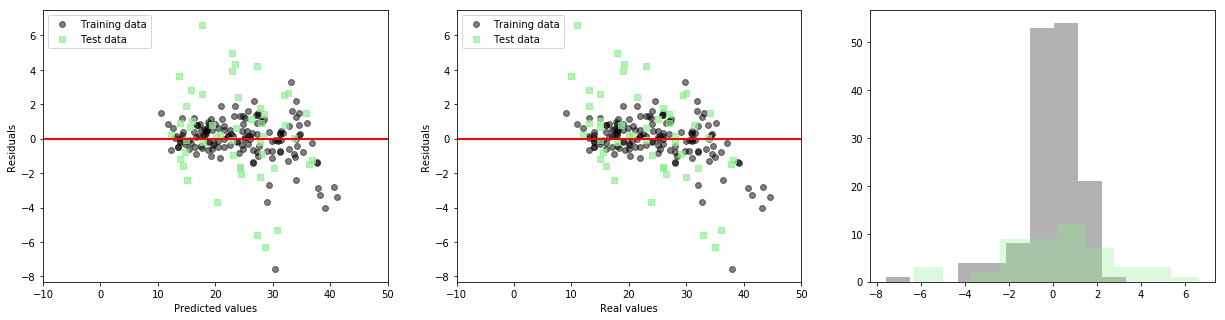

In [22]:
plot_residuals(y_train_pred, y_test_pred)

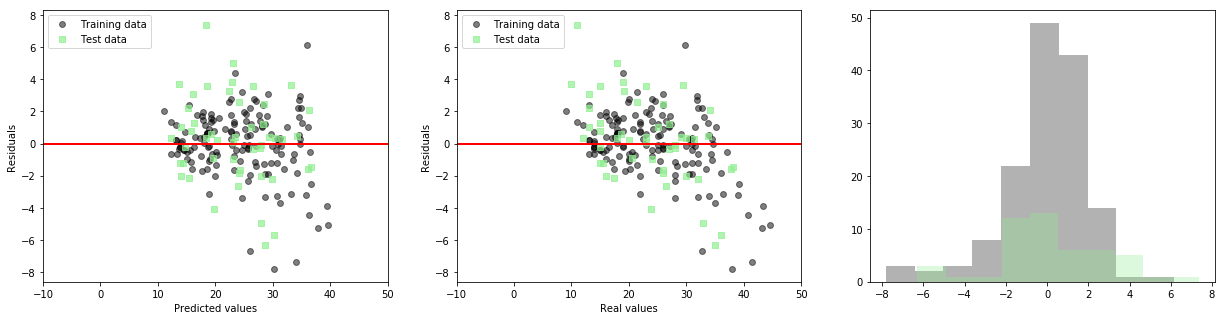

In [23]:
plot_residuals(best_y_train_pred, best_y_test_pred)

- 用語
    - 00データ = 欠損値除去
    - 01データ = 外れ値除去

- 全般
    - 訓練時、テスト時ともに、実際よりも大きく少なく予想してしまうことがある

- 00データ
    - 全般
        - 正規分布的
    - 訓練時
        - 大きな値（低燃費）ほど控え目な予想をしてはずす
    - テスト時
        - 低残差の件数が減っている
        - 大きな値（低燃費）ほど控え目な予想をしてはずす
        - 小さな値（高燃費）ほど強気　な予想をしてはずす

### レコードチェック

In [24]:
X_train_ret = X_train.copy()
X_train_ret['pred'] = best_y_train_pred
X_train_ret['mpg'] = y_train
X_train_ret['residuals'] = X_train_ret.mpg - X_train_ret.pred
X_train_ret.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,pred,mpg,residuals
92,6,200.0,85.0,3070.0,16.7,78,1,21.728892,20.8,-0.928892
185,4,105.0,74.0,1980.0,15.3,82,2,34.183444,36.0,1.816556
24,6,200.0,85.0,2990.0,18.2,79,1,22.410619,19.8,-2.610619
30,6,250.0,100.0,3781.0,17.0,74,1,16.418511,16.0,-0.418511
109,4,97.0,78.0,2300.0,14.5,74,2,25.913075,26.0,0.086925


In [25]:
X_test_ret = X_test.copy()
X_test_ret['pred'] = best_y_test_pred
X_test_ret['mpg'] = y_test
X_test_ret['residuals'] = X_test_ret.mpg - X_test_ret.pred
X_test_ret.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,pred,mpg,residuals
83,8,383.0,170.0,3563.0,10.0,70,1,18.600235,15.0,-3.600235
12,4,97.0,88.0,2130.0,14.5,70,3,26.653177,27.0,0.346823
33,4,121.0,110.0,2660.0,14.0,73,2,23.036709,24.0,0.963291
113,4,146.0,67.0,3250.0,21.8,80,2,30.375816,30.0,-0.375816
171,8,390.0,190.0,3850.0,8.5,70,1,15.811343,15.0,-0.811343


# 退避

## 精度平均

In [26]:
results = pd.DataFrame(columns=["model_name", "Hold-out", "Non-nested CV", "Nested CV", "Hold-out_best", "Non-nested CV_best"])

In [27]:
# ループで何度か実行し、スコアの推移を確認
for i in range(0, 5):
    (ret, y_train_pred, y_test_pred, best_y_train_pred, best_y_test_pred) = predict(rf_model, rf_model_cv, "r")
    results = results.append(ret)
results

,model_name,Hold-out,Non-nested CV,Nested CV,Hold-out_best,Non-nested CV_best
0,r,2.5995,2.983978,3.160588,2.525499,3.068194
0,r,2.5995,3.161231,3.087052,2.635523,3.119652
0,r,2.5995,3.120157,3.188327,2.510359,3.026242
0,r,2.5995,3.048596,3.131247,2.525499,2.977595
0,r,2.5995,3.172050,3.158007,2.635523,3.085934


In [28]:
results.mean()

Hold-out              2.599500
Non-nested CV         3.097202
Nested CV             3.145044
Hold-out_best         2.566481
Non-nested CV_best    3.055523
dtype: float64

# 考察

## 比較対象として、4/14時点のランキングデータ


- 投稿：1555件
- 参加：428人
- スコア
  - 1位：2.35474 (2019-02-15 21:49:02)
  - 5位：2.51207 (2019-02-01 18:48:02)
  - 6位：2.57726 (2019-02-01 00:39:02)
  - 10位：2.63501 (2019-03-04 02:03:02)
  - 40位：2.77689 (2018-08-23 17:26:02)
  - 100位：3.15333 (2018-10-05 00:21:02)

## とりあえずRF実施段階

- スコアが 3.109519 なので、工夫ナシで100位以下

## 方針

集計結果から、予測困難と思われるケース等を見つけ排除し、再度予想する